In [1]:
!export PYTORCH_ENABLE_MPS_FALLBACK=1

In [6]:
import os
import sys

os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

In [7]:
!$PYTORCH_ENABLE_MPS_FALLBACK

zsh:1: command not found: 1


In [8]:
#use darts to load data from data folder into a time series
from darts import TimeSeries

#load data from data folder
ts = TimeSeries.from_csv('../data/price_data_filtered.csv', parse_dates=True, index_col=0)

In [9]:
#convert the time series to float32
ts = ts.astype('float32')

Number of components is larger than 10 (14). Plotting only the first 10 components.


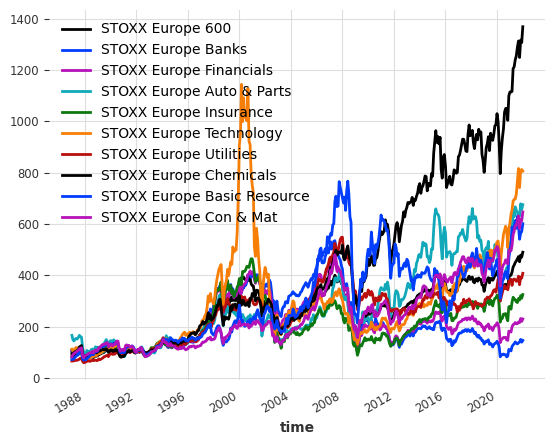

In [10]:
ts.plot()

In [11]:
#extract the STOXX EUROPE 600 index from the time series
ts.columns

Index(['STOXX Europe 600', 'STOXX Europe Banks', 'STOXX Europe Financials',
       'STOXX Europe Auto & Parts', 'STOXX Europe Insurance',
       'STOXX Europe Technology', 'STOXX Europe Utilities',
       'STOXX Europe Chemicals', 'STOXX Europe Basic Resource',
       'STOXX Europe Con & Mat', 'STOXX Europe Health Care',
       'STOXX Europe Inds Gds & Svs', 'STOXX Europe Media',
       'STOXX Europe Telecoms'],
      dtype='object', name='component')

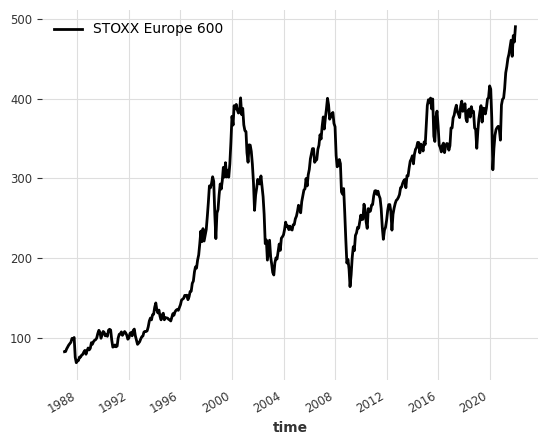

In [12]:
ts['STOXX Europe 600'].plot()

In [13]:
ts_stoxx = ts['STOXX Europe 600']

In [14]:
import pandas as pd

In [15]:
#split ts stoxx into train and test set, use 90% of the data for training
train, test = ts_stoxx.split_after(pd.Timestamp('2019-01-01'))

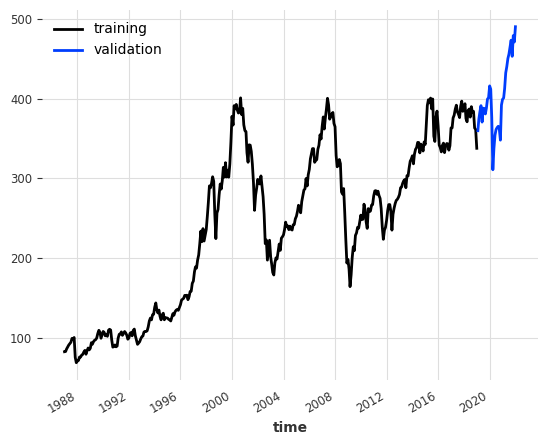

In [16]:
train.plot(label="training")
test.plot(label="validation")

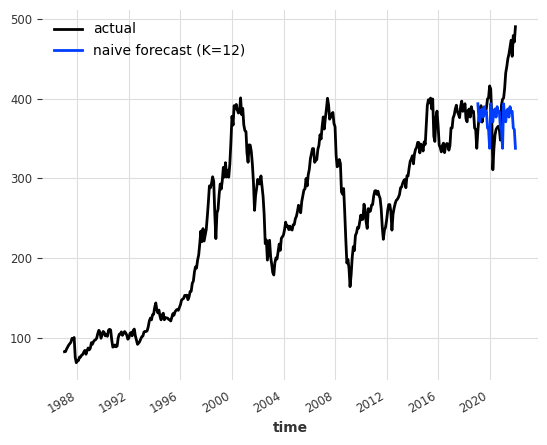

In [17]:
from darts.models import NaiveSeasonal
seasonal_model = NaiveSeasonal(K=12)
seasonal_model.fit(train)
seasonal_forecast = seasonal_model.predict(36)

ts_stoxx.plot(label="actual")
seasonal_forecast.plot(label="naive forecast (K=12)")

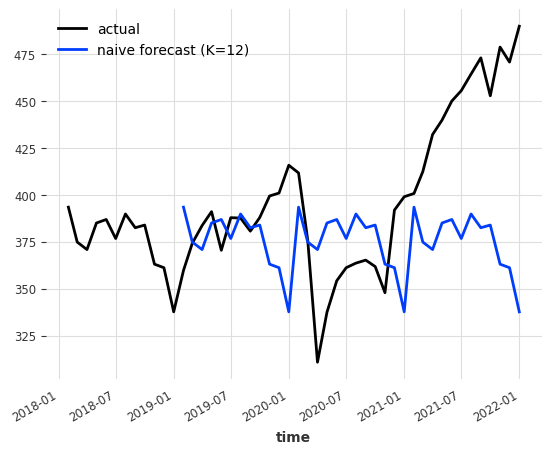

In [18]:
#plot only the last 48 months of the time series
ts_stoxx[-48:].plot(label="actual")
seasonal_forecast.plot(label="naive forecast (K=12)")

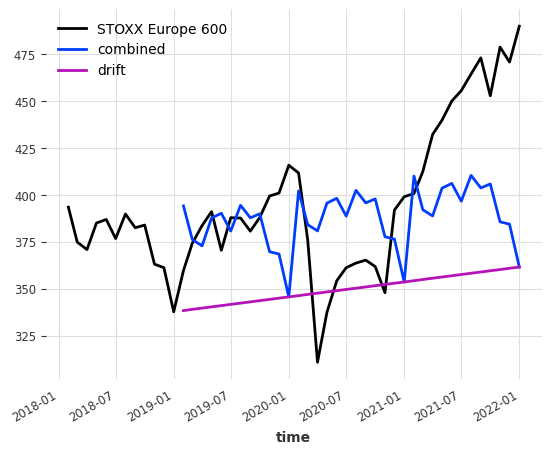

In [19]:
from darts.models import NaiveDrift

drift_model = NaiveDrift()
drift_model.fit(train)
drift_forecast = drift_model.predict(36)

combined_forecast = drift_forecast + seasonal_forecast - train.last_value()

ts_stoxx[-48:].plot()
combined_forecast.plot(label="combined")
drift_forecast.plot(label="drift")

# Transformer: darts

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import shutil
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import TransformerModel, ExponentialSmoothing
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf
from darts.datasets import AirPassengersDataset, SunspotsDataset

import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

In [21]:
torch.has_mps
CPU= False
device = "cpu" if CPU else torch.device("mps")
print("Device is :: {}".format(device))

Device is :: mps


In [22]:
#get the start and end date of ts
start_date = ts_stoxx.start_time()
end_date = ts_stoxx.end_time()
print("The time series starts at {} and ends at {}".format(start_date, end_date))

The time series starts at 1987-01-01 00:00:00 and ends at 2022-01-01 00:00:00


In [23]:
#make train val split to use the last 12 months as validation set
train, val = ts.split_after(pd.Timestamp('2019-01-01'))

In [24]:
scaler = Scaler()
train_scaled = scaler.fit_transform(train)
val_scaled = scaler.transform(val)
series_scaled = scaler.transform(ts)

In [25]:
"the dataset has {} data points".format(len(ts))

'the dataset has 421 data points'

In [38]:
my_model = TransformerModel(
    input_chunk_length=24,
    output_chunk_length=12,
    batch_size=64,
    n_epochs=200,
    model_name="test_model",
    nr_epochs_val_period=10,
    d_model=16,
    nhead=8,
    num_encoder_layers=6,
    num_decoder_layers=6,
    dim_feedforward=128,
    dropout=0.1,
    activation="relu",
    random_state=42,
    save_checkpoints=True,
    force_reset=True,
    pl_trainer_kwargs={
    "accelerator": "gpu",
    "devices": [0],
    "precision": 32
    },
)

In [39]:
my_model.fit(series=train_scaled, val_series=val_scaled, verbose=True)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [40]:
%env PYTORCH_ENABLE_MPS_FALLBACK=1

env: PYTORCH_ENABLE_MPS_FALLBACK=1


env: PYTORCH_ENABLE_MPS_FALLBACK=1


Predicting: 0it [00:00, ?it/s]

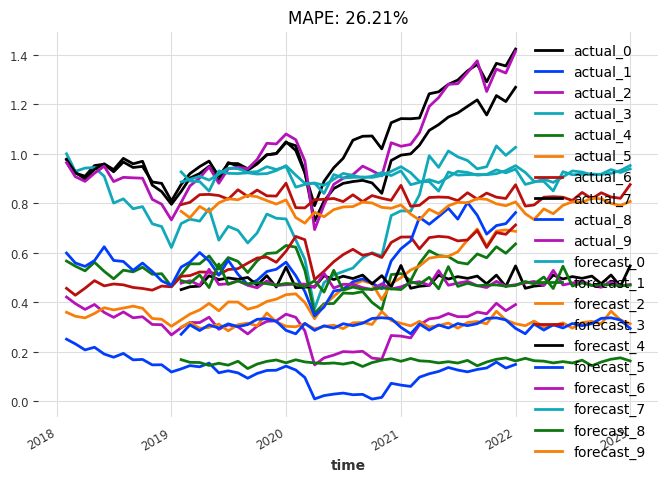

In [41]:
%env PYTORCH_ENABLE_MPS_FALLBACK=1
# this function evaluates a model on a given validation set for n time-steps
def eval_model(model, n, series, val_series):
    pred_series = model.predict(n=n)
    plt.figure(figsize=(8, 5))
    series[-48:].plot(label="actual")
    pred_series.plot(label="forecast")
    plt.title("MAPE: {:.2f}%".format(mape(pred_series, val_series)))
    plt.legend()


eval_model(my_model, 48, series_scaled, val_scaled)

In [52]:
pred_series = my_model.predict(n=36)

Predicting: 0it [00:00, ?it/s]

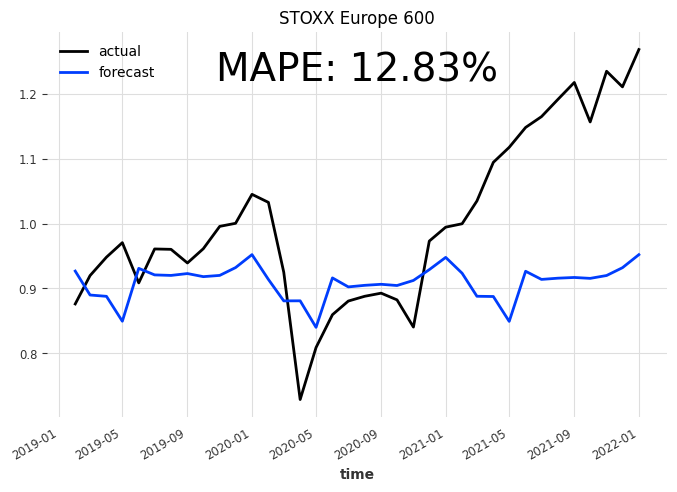

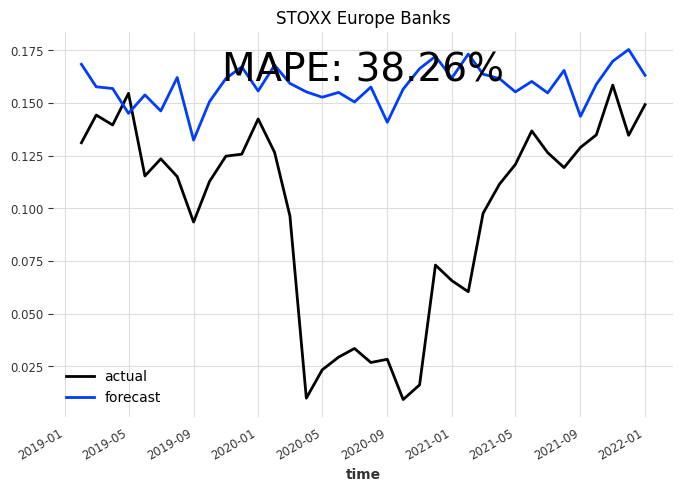

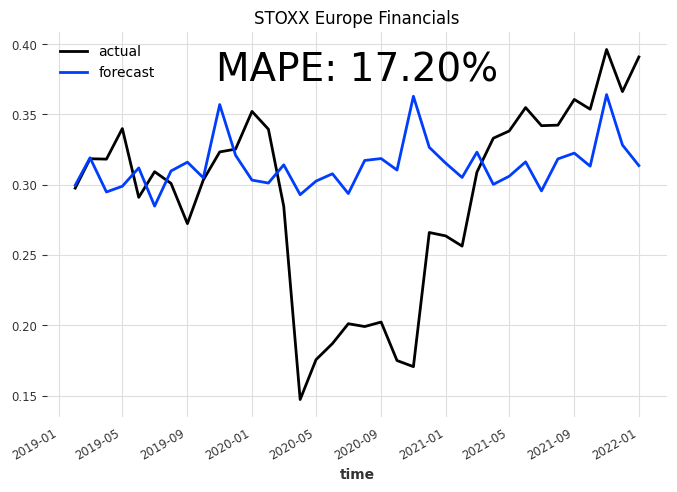

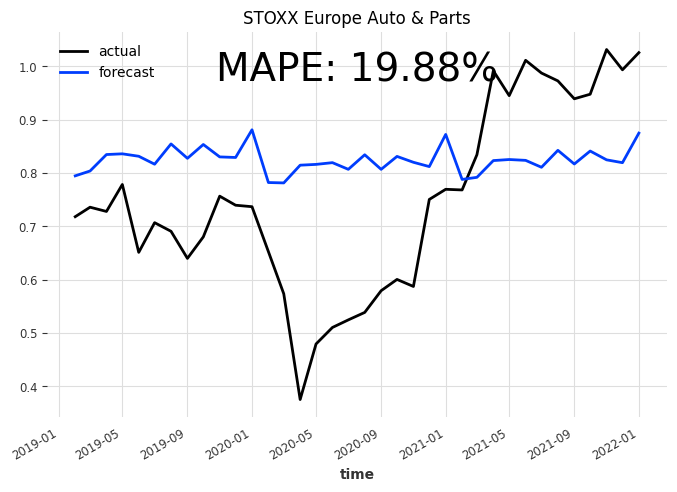

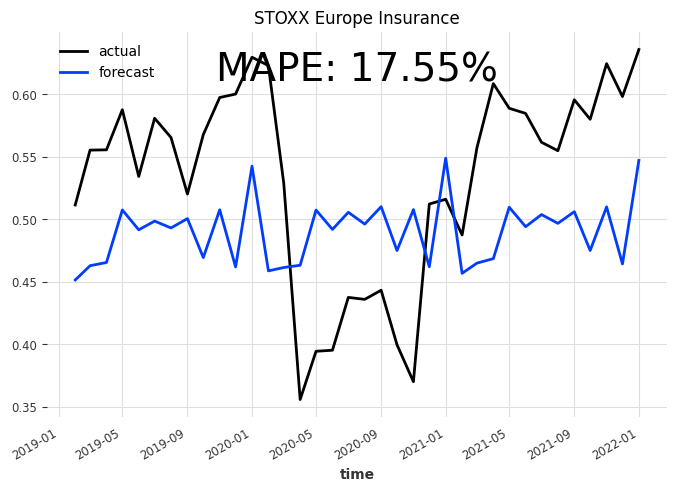

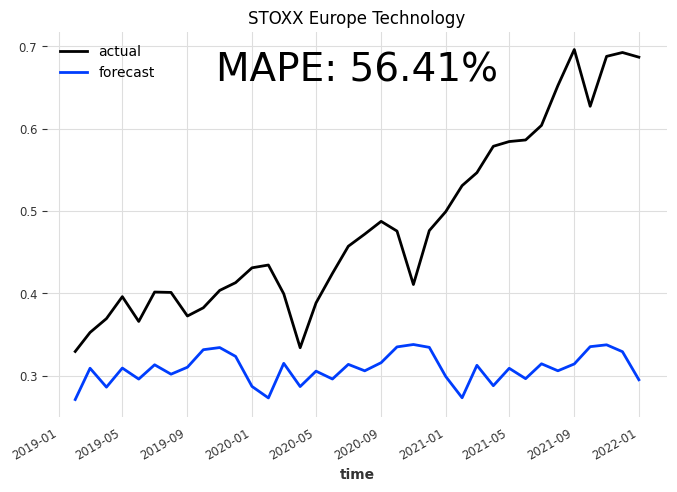

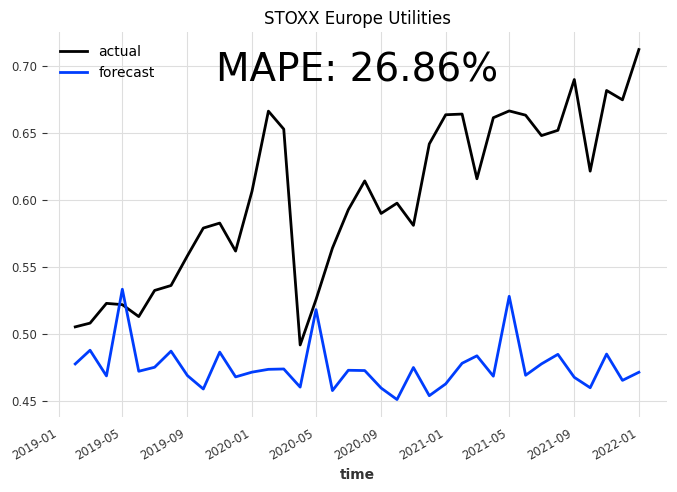

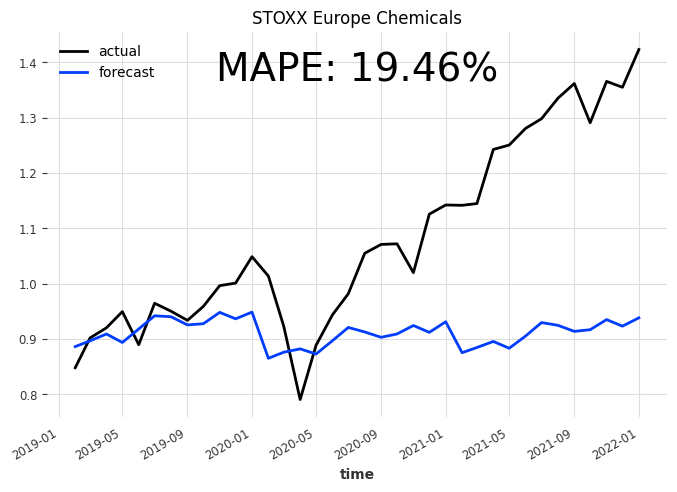

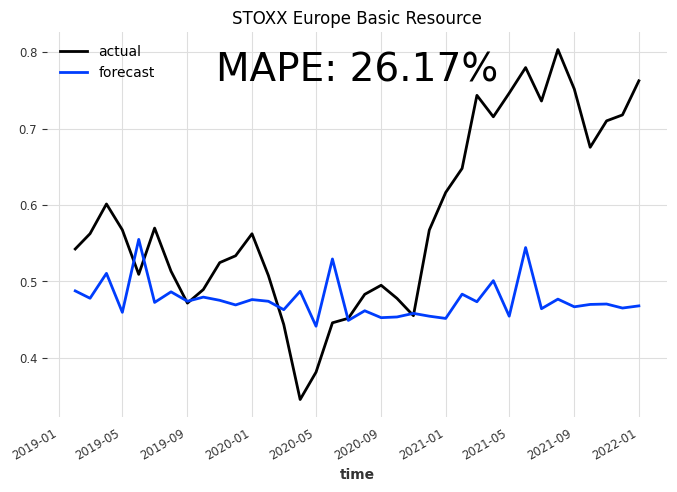

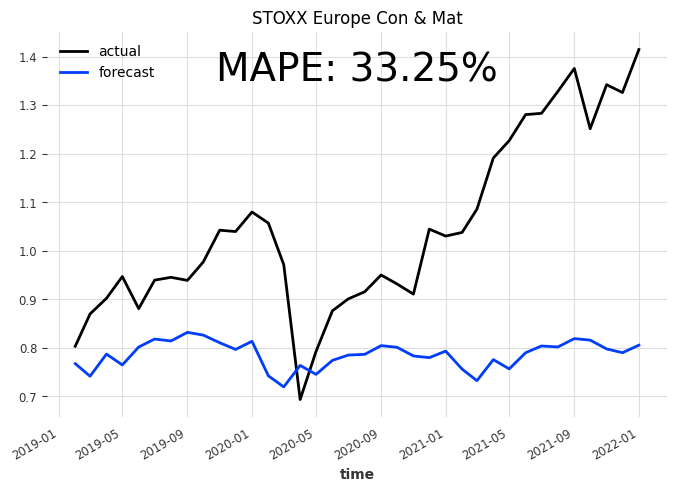

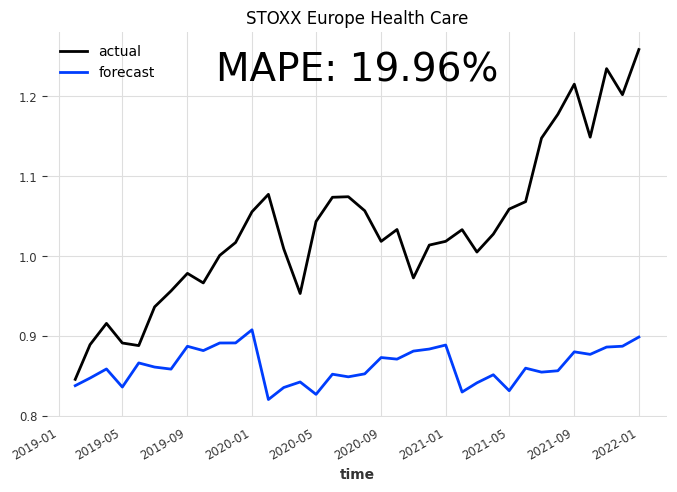

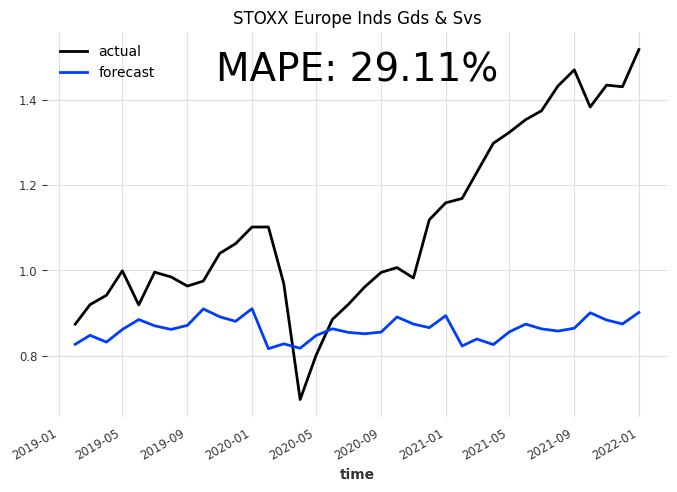

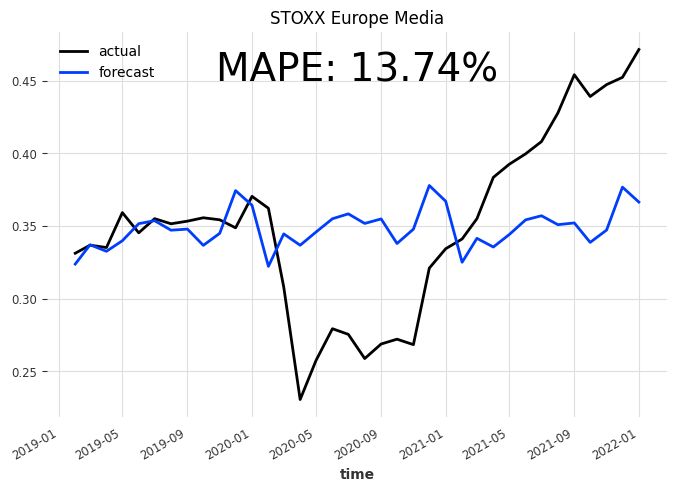

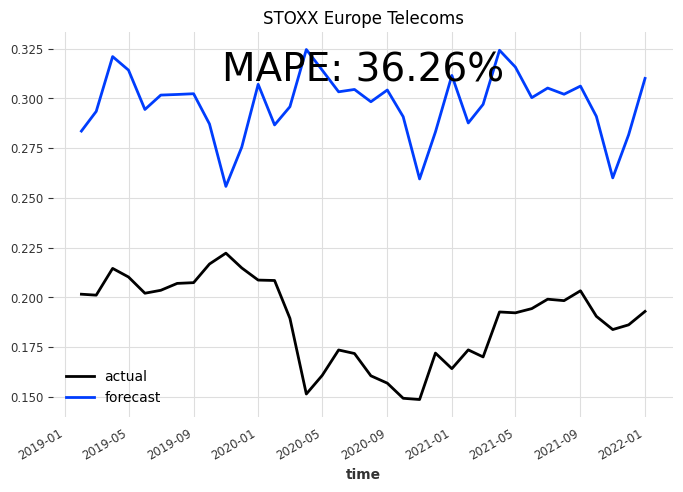

In [61]:
for col in pred_series.columns:
    #create an individual plot for each column
    plt.figure(figsize=(8, 5))
    #plot the actual values
    series_scaled[col][-36:].plot(label="actual")
    #plot the predicted values
    pred_series[col].plot(label="forecast")
    #set the title of the plot
    plt.title(col)
    #print the mape under the title
    text_kwargs = dict(ha='center', va='center', fontsize=28, color='C0')
    plt.text(0.5, 0.9, "MAPE: {:.2f}%".format(mape(pred_series[col], val_scaled[col])), transform=plt.gca().transAxes, **text_kwargs)
    #show the legend
    plt.legend()
    #show the plot
    plt.show()